# <p align="center">Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado</p>


# <p align="center">Microproyecto 1</p>


### <p align="center">Camilo Rodriguez</p>
### <p align="center">Monica Alvarez</p>



Lo primero que se hace es importar las librerías necesarias para el desarrollo del proyecto.

Como librerías principales se utilizan:
- OpenCV
- Matplotlib
- Scikit-learn


In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator

from scipy.cluster.hierarchy import linkage
from kmedoids import KMedoids  

Se descargaron las imágenes de la base de datos proporcionada por el profesor, junto con un archivo CSV que contiene la información de las imágenes, tanto urls, como artista y estilo de la obra.

Lo primero que se hace es cargar el archivo CSV y visualizar la información que contiene.

In [2]:
clases = pd.read_csv('classes.csv')
clases.head(5)

filename         artist  \
0  Abstract_Expressionism/aaron-siskind_acolman-1...  aaron siskind   
1  Abstract_Expressionism/aaron-siskind_chicago-6...  aaron siskind   
2  Abstract_Expressionism/aaron-siskind_glouceste...  aaron siskind   
3  Abstract_Expressionism/aaron-siskind_jerome-ar...  aaron siskind   
4  Abstract_Expressionism/aaron-siskind_kentucky-...  aaron siskind   

                        genre          description             phash  width  \
0  ['Abstract Expressionism']       acolman-1-1955  bebbeb018a7d80a8   1922   
1  ['Abstract Expressionism']       chicago-6-1961  d7d0781be51fc00e   1382   
2  ['Abstract Expressionism']  gloucester-16a-1944  9f846e5a6c639325   1382   
3  ['Abstract Expressionism']  jerome-arizona-1949  a5d691f85ac5e4d0   1382   
4  ['Abstract Expressionism']      kentucky-4-1951  880df359e6b11db1   1382   

   height  genre_count subset  
0    1382            1  train  
1    1746            1  train  
2    1857            1  train  
3    1849            1  train  
4    1625            1  train

Al momewnto de descomprime el archivo de imagenes se obseva qeu imagenes con titulos que contienen caracteres especiales no se descomprimen correctamente, por lo que se procede filtar las imagenes que tienen el titulo correctamente, eso se logra con expresiones regulares.

In [4]:
clases_filtred = clases[clases['filename'].str.contains(r'^[a-zA-Z0-9_/\-.]+$', regex=True)] #filtro titulo de las imagenes
clases_filtred['path'] = 'archive/' + clases_filtred['filename'] #agrego la ruta de las imagenes

/var/folders/18/88x5gxxj0wq949rkr1_qj3_45113mn/T/ipykernel_51525/665221271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clases_filtred['path'] = 'archive/' + clases_filtred['filename'] #agrego la ruta de las imagenes


Con los titulos de las imagenes filtradas se procede tomar un subconjunto de las imagenes para trabajar con ellas, en este caso se toman dos imagenes para hacer pruebas de los modelos.

In [7]:
images_random = clases_filtred['path'].sample(n=2)
images_random

79934    archive/Ukiyo_e/utagawa-kuniyoshi_kuroda-ukina...
32709    archive/Minimalism/sol-lewitt_serial-project-s...
Name: path, dtype: object

Con la direccion de la imagen se procede a cargarla y redimensionarla para poder trabajar con ella.

El valor de la redimensión se toma de 224x224 pixeles.

Se guaradan estas imagenes redimensionadas en una lista llamada "images".

In [9]:
images = []
for ima in  images_random:
    image = cv2.imread(ima)
    image_resized = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)
    images.append(image_resized)

La siguente funcion "optimal_cluster_number" busca por medio de la técnica de "Elbow Method" el número óptimo de clusters para la imagen que se le pase como parámetro.

In [10]:
def optimal_cluster_number(data):
    silhouette_scores = []
    inertias = []
    min_k = 3 # Mínimo número de clusters
    max_clusters=9 # Número máximo de clusters para liomitar la busqueda
    k_range = range(min_k, max_clusters + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42) # Inicialización del modelo
        kmeans.fit(data) # fitteo del modelo
        silhouette_scores.append(silhouette_score(data, kmeans.labels_)) # Cálculo del silhouette score
        inertias.append(kmeans.inertia_) # Cálculo de la inercia
    
    # Normalizar inercias para la visualización
    inertias = np.array(inertias)
    inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
    
    # Encontrar el número óptimo de clusters
    k_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_k
    k_elbow = np.argmin(np.diff(inertias)) + min_k
    
    # Visualizar los métodos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Silhouette score
    ax1.plot(k_range, silhouette_scores)
    ax1.plot(k_silhouette, silhouette_scores[k_silhouette-min_k], 'ro')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Method')
    
    # Elbow method
    ax2.plot(k_range, inertias)
    ax2.plot(k_elbow, inertias[k_elbow-min_k], 'ro')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Inertia (normalized)')
    ax2.set_title('Elbow Method')
    
    plt.tight_layout()
    plt.show()
    
    # Retornar el promedio de los dos métodos
    return int((k_silhouette + k_elbow) / 2)
    

La función "show_image_and_palette" se encarga de  entrenar el modelo KMeans con la imagen que se le pase como parámetro y mostrar la imagen original junto con la paleta de colores generada por el modelo.

Al inicio de la funacion se hace un pequeño preprocesamiento de la imagen, se cambia de canal de color BGR a RGB, se hace un reshape de la imagen para que quede en un formato de 2D, y se normaliza la imagen. Se hacer el entremenamiento del mdoelo  para luego hacer una tranformacion inversa de los centrides para poder visualizar la imagen original.

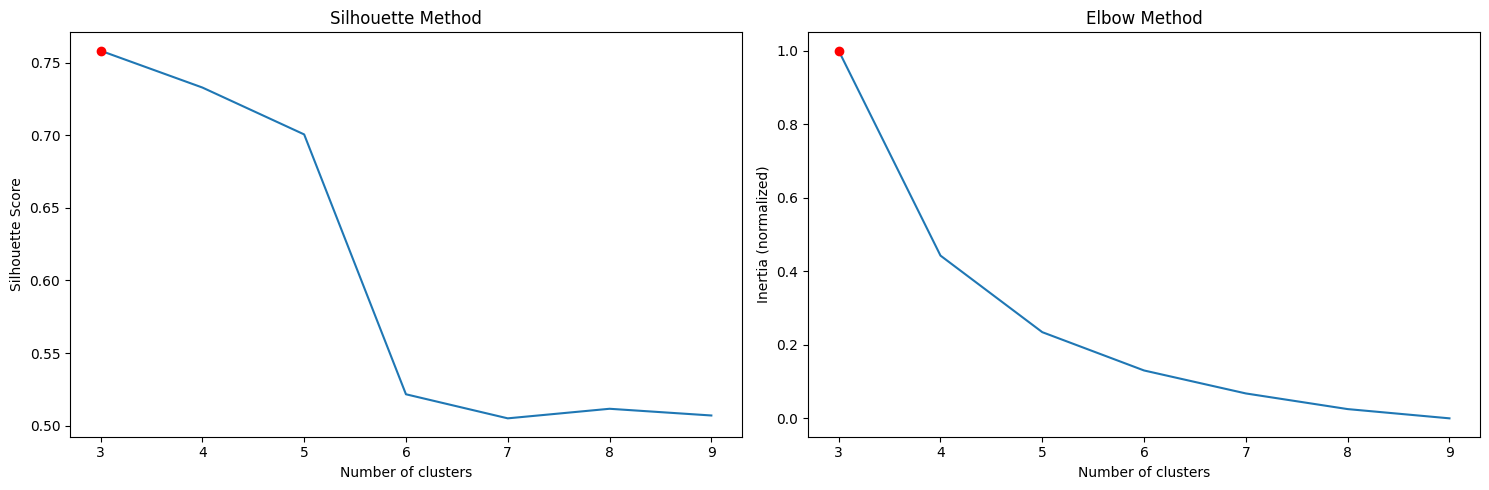

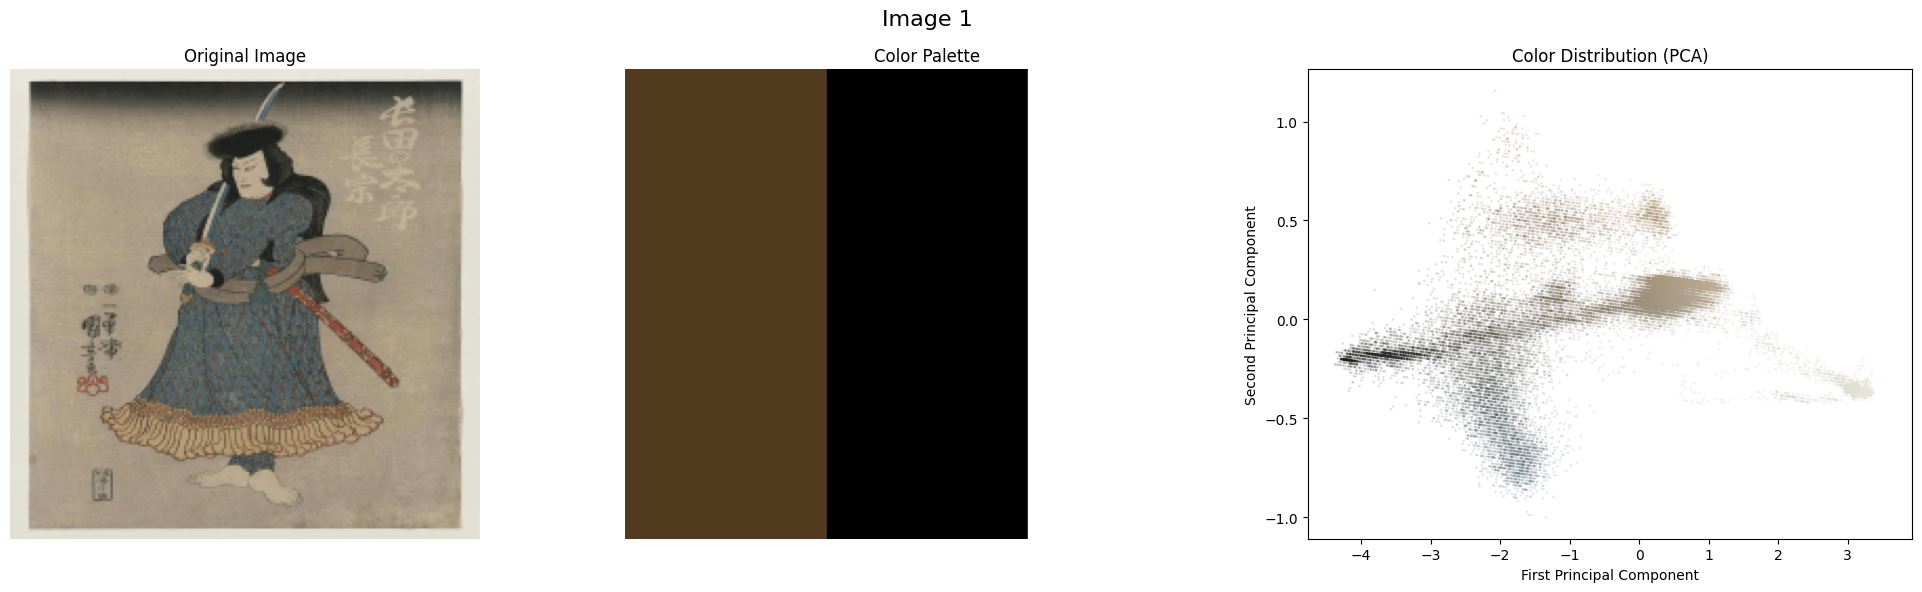

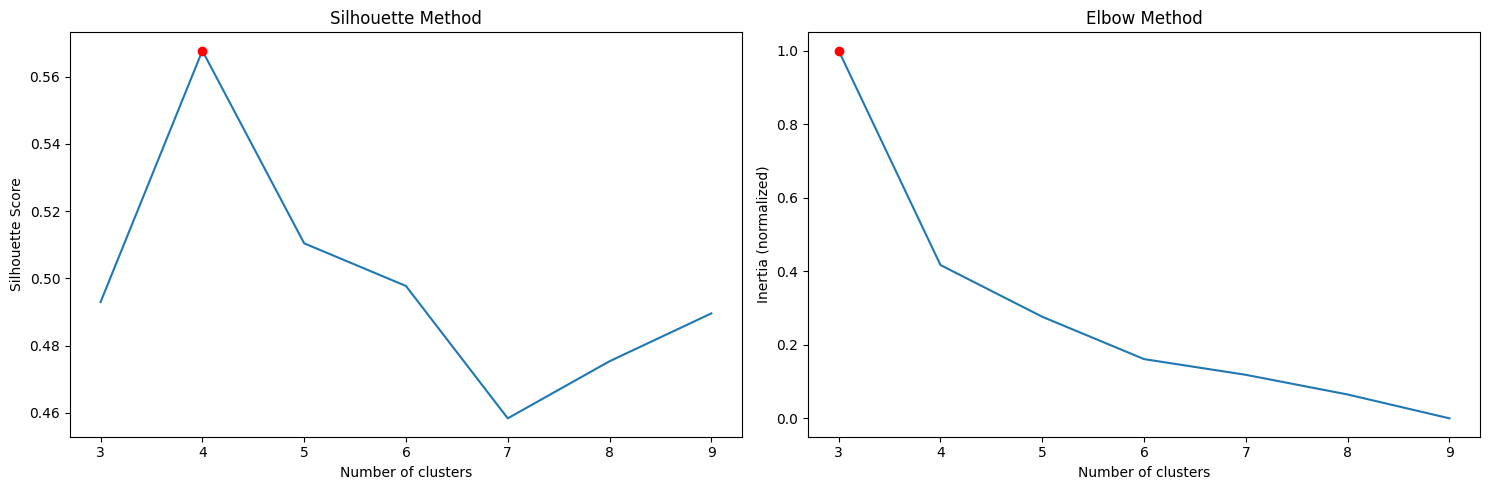

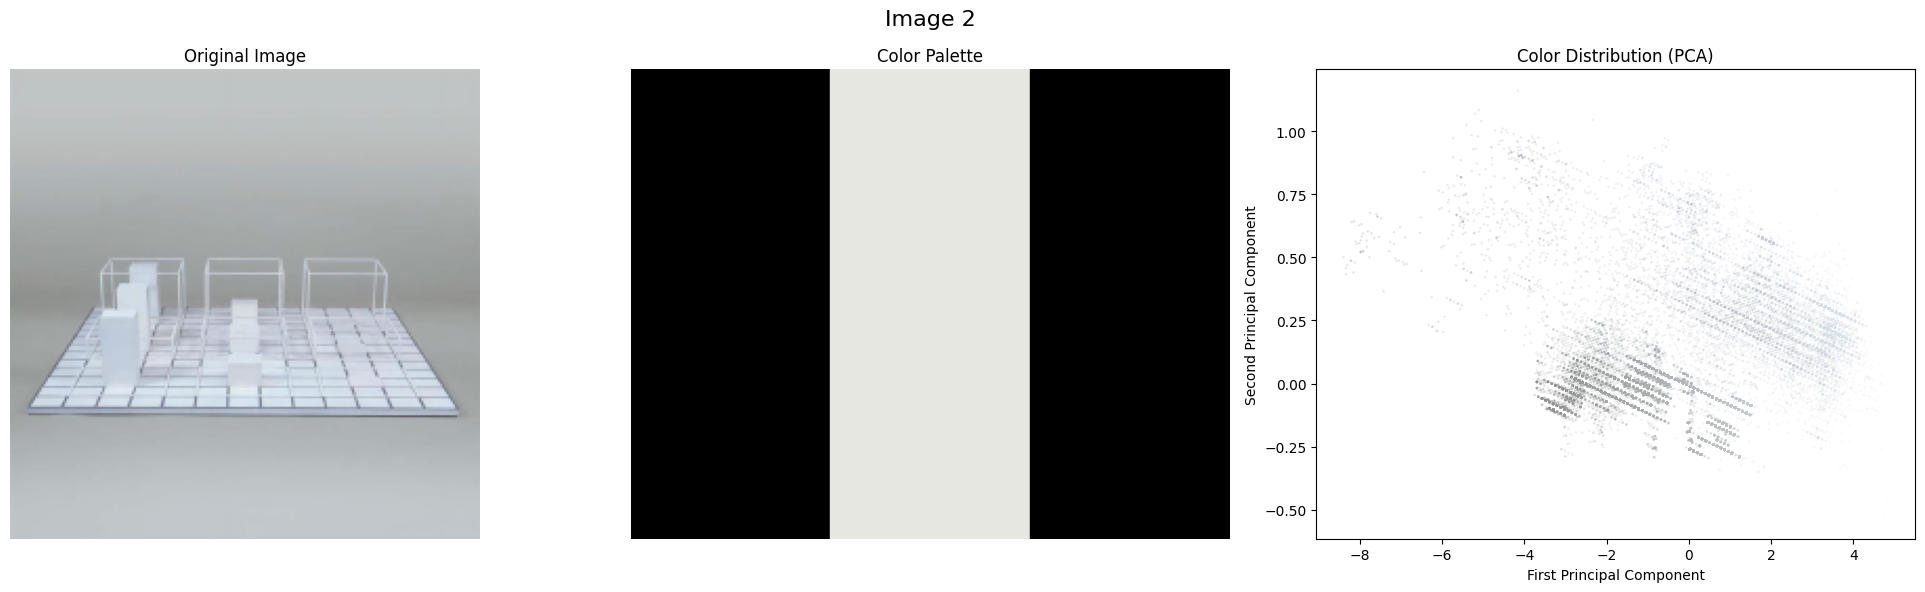

In [11]:
def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convertir la imagen a RGB
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    n_colors = optimal_cluster_number(normalized_imag)

    kmeans = KMeans(n_clusters=n_colors, random_state=42)


    kmeans.fit(normalized_imag)

    colors = kmeans.cluster_centers_
    colors = np.clip(colors * 255, 0, 255).astype(int)


    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)
    
    #unque_colors = np.unique(colors, axis=0)
    #unque_colors = colors
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')


    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title('Color Palette')

    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)


En la siguente funcion "show_image_and_palette_kmedoids" se hace lo mismo que en la funcion anterior, pero en este caso se utiliza el modelo KMedoids. Cabe resaltar que el modelo KMedoids es un modelo más robusto que el KMeans, ya que en lugar de calcular los centroides de los clusters, se calculan los puntos más cercanos al centroide, esto se traduce en un mayor tiempo de ejecución del modelo sin que haya pie a la optimización de los clusters. Se dejo correindo el modelo KMedoids con 8 clusters para que se pueda comparar con el modelo KMeans por 8 horas y no convergio, por lo que se decidio no incluirlo en el proyecto.

In [12]:
def show_image_and_palette_kmedoids(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{title} - Original Image")
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    kmedoids = KMedoids(n_clusters=8, random_state=42, metric='euclidean')
    kmedoids.fit(normalized_imag)

    colors = kmedoids.cluster_centers_
    colors = np.clip(colors * 255, 0, 255).astype(int)

    plt.subplot(1, 2, 2)
    for i, color in enumerate(colors):
        plt.axvspan(i, i+1, color=color/255)
    plt.axis('off')
    plt.title(f"{title} - Color Palette")
    
    plt.tight_layout()
    plt.show()

    return colors


palettes = []
titles = []

for i, image in enumerate(images[:2]):
    title = f"Image {i+1}"
    palette = show_image_and_palette_kmedoids(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)

La siguientye funcion "optimal_cluster_number_linkage" busca por medio de la técnica de distancias de Ward el número óptimo de clusters para la imagen que se le pase como parámetro.

In [13]:
def optimal_cluster_number_linkage(data):
    max_clusters=7 # Número máximo de clusters para limitar la busqueda
    # Calcular la matriz de enlace
    linkage_matrix = linkage(data, method='ward') # Método de enlace
    
    # Calcular las distancias de enlace para diferentes números de clusters
    last = linkage_matrix[-max_clusters:, 2] # Últimos max_clusters elementos
    last_rev = last[::-1] # Revertir el orden
    idxs = np.arange(1, len(last) + 1) # Índices para el número de clusters
    
    # Calcular la aceleración de la curva
    acceleration = np.diff(last_rev, 2) # Segunda derivada de la curva
    acceleration_rev = acceleration[::-1] # Revertir el orden
    
    k = acceleration_rev.argmax() + 2  # El número óptimo de clusters
    
    # Visualizar el método del codo
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(idxs, last_rev)
    plt.plot(idxs[k-1], last_rev[k-1], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Linkage distance')
    plt.title('Elbow Method for Optimal k')
    
    # Visualizar la aceleración
    plt.subplot(122)
    plt.plot(idxs[:-2], acceleration_rev)
    plt.plot(idxs[k-2], acceleration_rev[k-2], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Acceleration of linkage distance')
    plt.title('Acceleration Method for Optimal k')
    
    plt.tight_layout()
    plt.show()
    
    return k

La siguente funcion "show_image_and_palette_AgglomerativeClustering" se encarga de  entrenar el modelo AgglomerativeClustering con la imagen que se le pase como parámetro y mostrar la imagen original junto con la paleta de colores generada por el modelo. Al igual que la funcion de KMeans, se hace un pequeño preprocesamiento de la imagen, se cambia de canal de color BGR a RGB, se hace un reshape de la imagen para que quede en un formato de 2D, y se normaliza la imagen. Se hacer el entremenamiento del modelo  para luego hacer una tranformacion inversa de los centrides para poder visualizar la imagen original.

Tamien se apliaca PCA a la imagen para poder visualizar la imagen en 2D y poder comparar los resultados de los modelos.

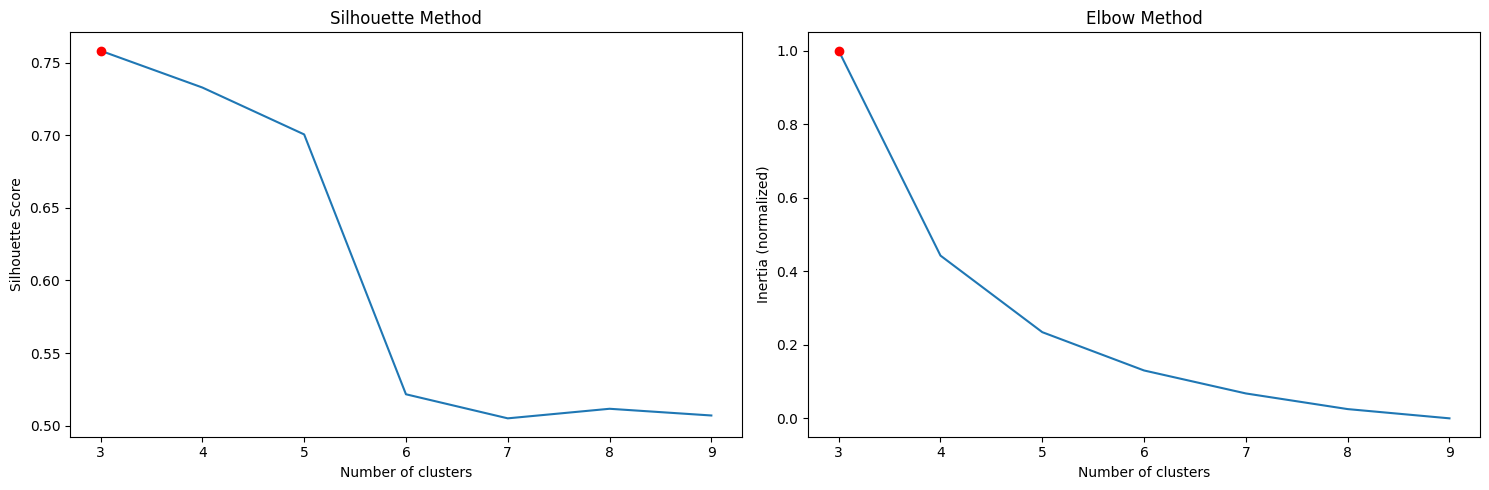

Optimal number of clusters for Image 1: 3


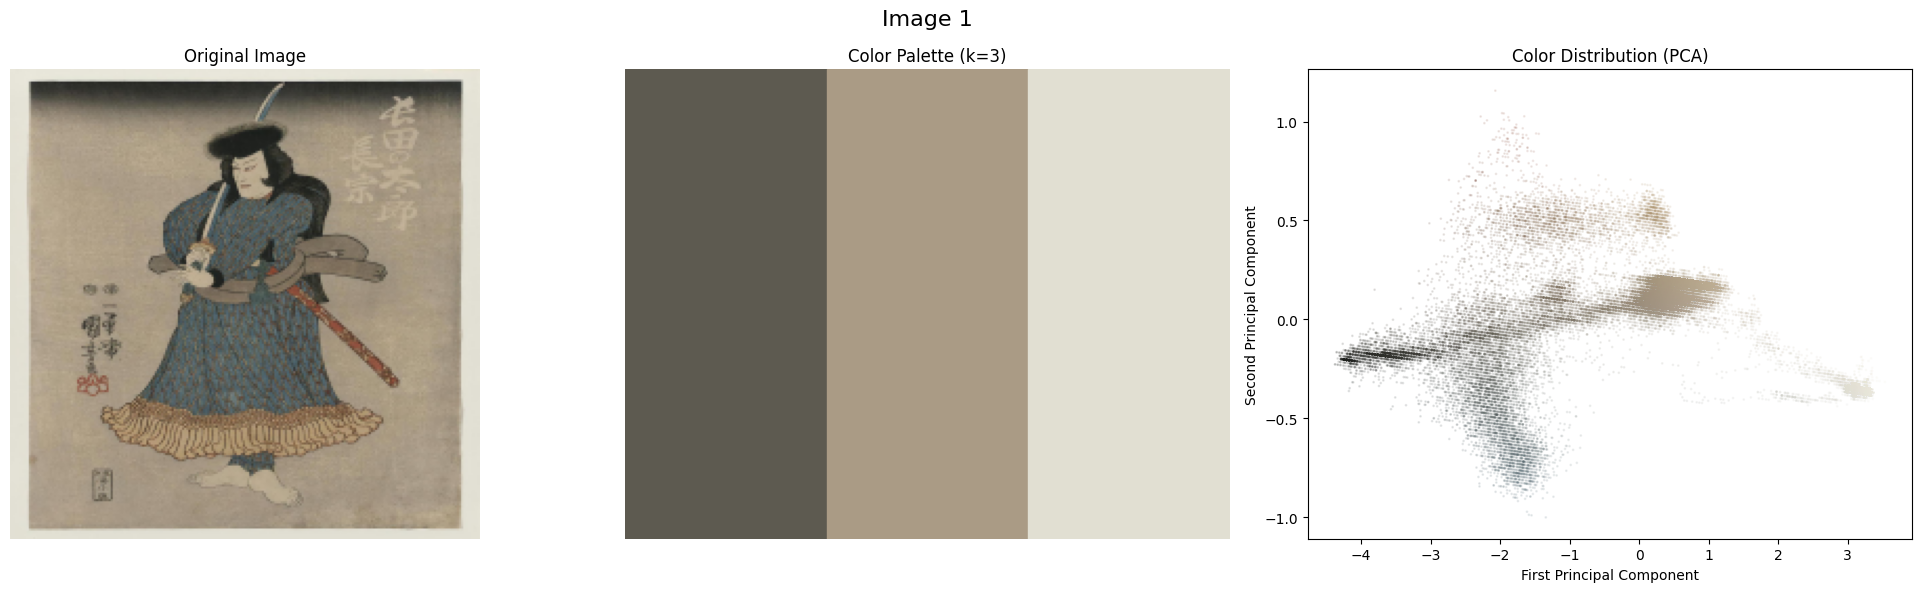

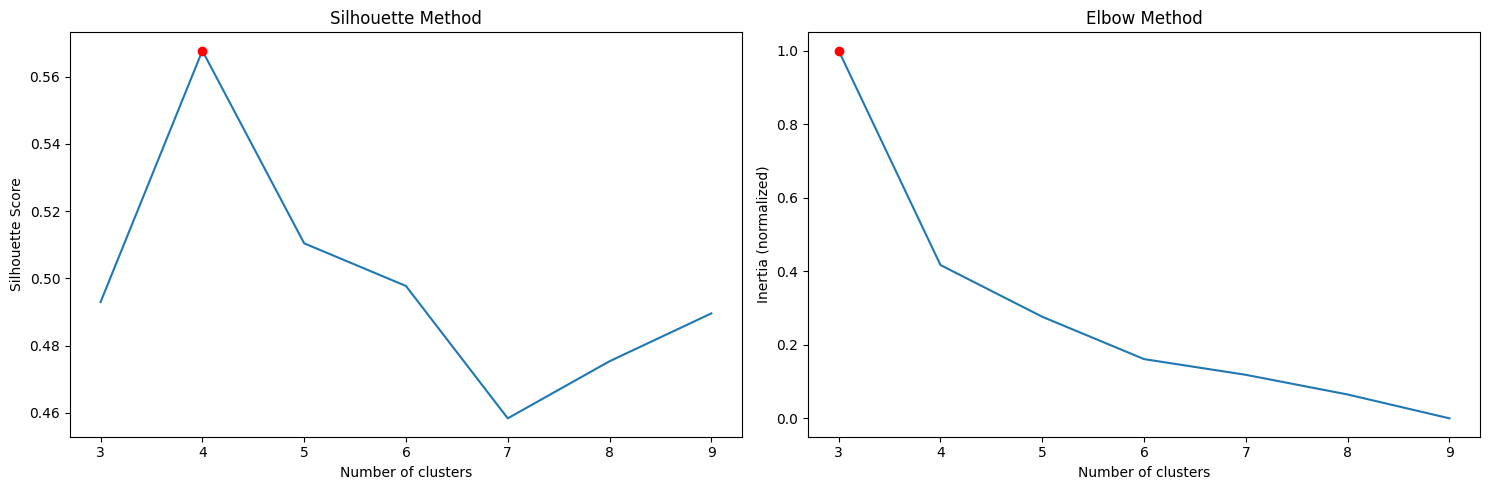

Optimal number of clusters for Image 2: 3


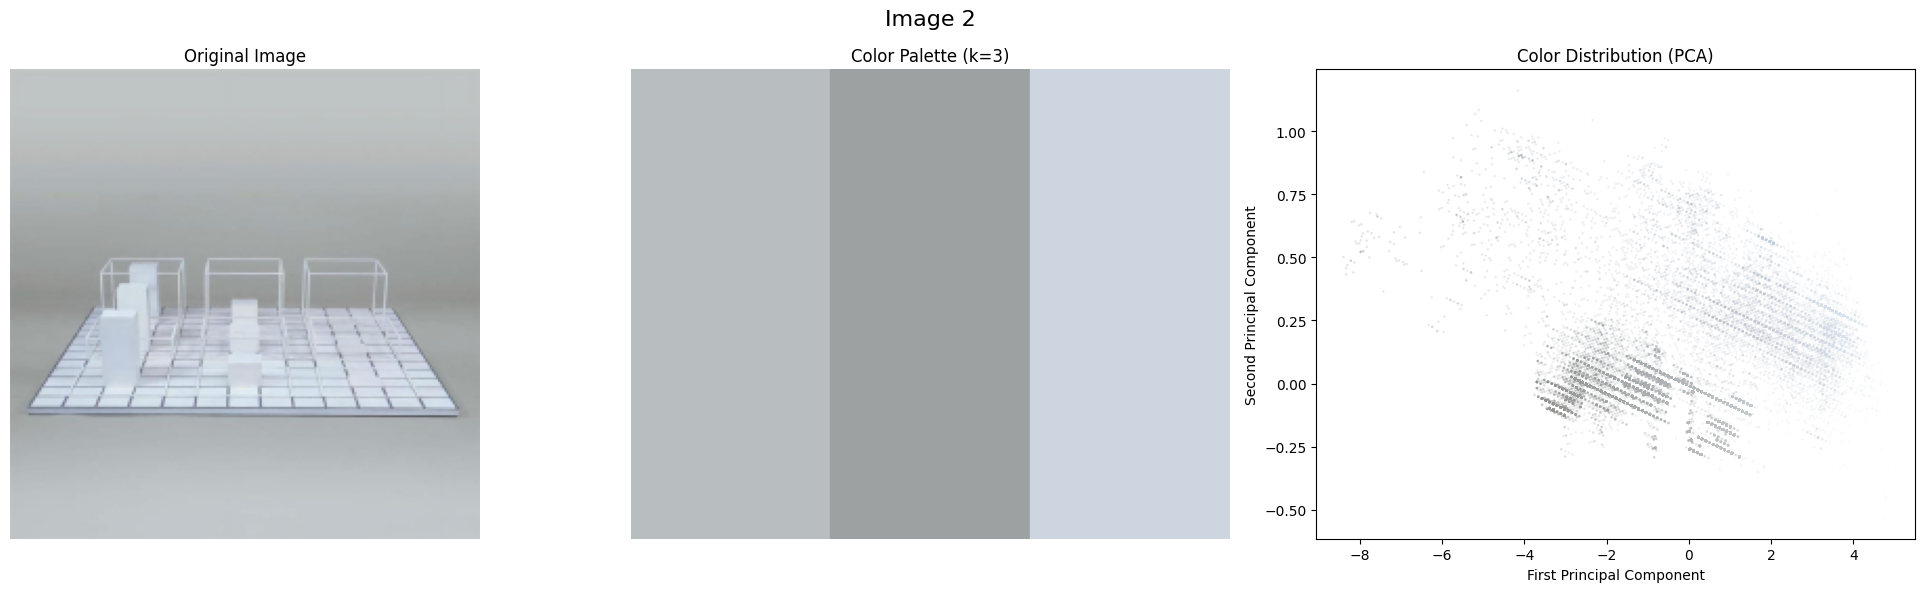

In [15]:
def show_image_and_palette_AgglomerativeClustering(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    n_colors = optimal_cluster_number(normalized_imag)
    print(f"Optimal number of clusters for {title}: {n_colors}")

    agglo = AgglomerativeClustering(n_clusters=n_colors)
    agglo.fit(normalized_imag)

    colors = []
    for i in range(n_colors):
        cluster_pixels = ima[agglo.labels_ == i]
        avg_color = np.mean(cluster_pixels, axis=0)
        colors.append(avg_color)

    
    colors = np.array(colors)
    colors = np.clip(colors, 0, 255).astype(int)

    # Aplicar PCA
    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)

    # Crear la visualización
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)

    # Mostrar la imagen original
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')

    # Mostrar la paleta de colores
    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title(f'Color Palette (k={n_colors})')

    # Visualizar la distribución de colores con PCA
    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)

## Creación pipeline

In [100]:
class ReadImages(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
       
    
    def transform(self, X):
        return cv2.imread(X)


In [114]:
class ImagePreprocessor(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # El preprocesamiento en sí se hace en el transform
        return self

    def transform(self, X, y=None):
        image_resized = cv2.resize(X, (224,224), interpolation=cv2.INTER_AREA)
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        ima = image_rgb.reshape(-1, 3)
        scaler = StandardScaler()
        normalized_imag = scaler.fit_transform(ima)
        return [normalized_imag, image_rgb, ima]

In [151]:
class ModelEvaluation(BaseEstimator):
    def __init__(self, model = 'aglo'):
        self.model = model
        pass

    def optimal_cluster_numbe_aglo(self, data, max_clusters=7):

        self.plot_list = []

        linkage_matrix = linkage(data, method='ward')
    
        # Calcular las distancias de enlace para diferentes números de clusters
        last = linkage_matrix[-max_clusters:, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        
        # Calcular la aceleración de la curva
        acceleration = np.diff(last_rev, 2)
        acceleration_rev = acceleration[::-1]
        
        k = acceleration_rev.argmax() + 2  # El número óptimo de clusters


        self.plot_list.append(idxs)
        self.plot_list.append(last_rev)
        self.plot_list.append(acceleration_rev)
        self.plot_list.append(k)

        return k
    
    

    def optimal_cluster_number_km(self, data, max_clusters=7):


        self.plot_list = []
    
        silhouette_scores = []
        inertias = []
        min_k = 5
        k_range = range(min_k, max_clusters + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data)
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
            inertias.append(kmeans.inertia_)
        
        # Normalizar inercias para la visualización
        inertias = np.array(inertias)
        inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
        
        # Encontrar el número óptimo de clusters
        k_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_k
        k_elbow = np.argmin(np.diff(inertias)) + min_k

        self.plot_list.append(k_range)
        self.plot_list.append(silhouette_scores)
        self.plot_list.append(k_silhouette)
        self.plot_list.append(min_k)
        self.plot_list.append(inertias)
        self.plot_list.append(k_elbow)


        # Retornar el promedio de los dos métodos
        return int((k_silhouette + k_elbow) / 2)
    
    
    def fit(self, X, y=None):

        normalized_imag, image_rgb, ima  = X

        if self.model == 'aglo':
            n_colors = self.optimal_cluster_numbe_aglo(normalized_imag)
            agglo = AgglomerativeClustering(n_clusters=n_colors)
            agglo.fit(normalized_imag)

            colors = []
            for i in range(n_colors):
                cluster_pixels = ima[agglo.labels_ == i]
                avg_color = np.mean(cluster_pixels, axis=0)
                colors.append(avg_color)
    
            colors = np.array(colors)
            self.colors = np.clip(colors, 0, 255).astype(int)

            #self.colors = [np.mean(ima[agglo.labels_ == i], axis=0) for i in range(n_colors)]

        else:
            n_colors = self.optimal_cluster_number_km(normalized_imag)

            kmeans = KMeans(n_clusters=n_colors, random_state=42)
            kmeans.fit(normalized_imag)

            colors = kmeans.cluster_centers_
            self.colors = np.clip(np.array(colors) * 255, 0, 255).astype(int)

        return self


    def transform(self, X):

        normalized_img, image_rgb, ima = X  

        # Aplicar PCA
        pca = PCA(n_components=2)
        pixels_2d = pca.fit_transform(normalized_img)

        if self.model == 'aglo':
            self.plot_ag()
        else:
            self.plot_km()

        # Crear la visualización
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        #fig.suptitle(title, fontsize=16)

        # Mostrar la imagen original
        ax1.imshow(image_rgb)
        ax1.axis('off')
        ax1.set_title('Original Image')

        # Mostrar la paleta de colores
        for i, color in enumerate(self.colors):
            ax2.axvspan(i, i+1, color=color/255)
        ax2.set_xlim(0, len(self.colors))
        ax2.axis('off')
        ax2.set_title(f'Color Palette (k={self.colors})')

        # Visualizar la distribución de colores con PCA
        ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
        ax3.set_title('Color Distribution (PCA)')
        ax3.set_xlabel('First Principal Component')
        ax3.set_ylabel('Second Principal Component')

        plt.tight_layout()
        plt.show()



    def plot_ag(self):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  
        ax1.plot(self.plot_list[0], self.plot_list[1])
        ax1.plot(self.plot_list[0][self.plot_list[3]-1], self.plot_list[1][self.plot_list[3]-1], 'ro')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Linkage distance')
        ax1.set_title('Elbow Method for Optimal k')
        
        # Visualizar la aceleración

        ax2.plot(self.plot_list[0][:-2], self.plot_list[2])
        ax2.plot(self.plot_list[0][self.plot_list[3]-2], self.plot_list[2][self.plot_list[3]-2], 'ro')
        ax2.set_xlabel('Number of clusters')
        ax2.set_ylabel('Acceleration of linkage distance')
        ax2.set_title('Acceleration Method for Optimal k')
                
        plt.tight_layout()
        plt.show()

    def plot_km(self):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Silhouette score
        ax1.plot(self.plot_list[0], self.plot_list[1])
        ax1.plot(self.plot_list[2], self.plot_list[1][self.plot_list[2]-self.plot_list[3]], 'ro')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Method')
        
        # Elbow method
        ax2.plot(self.plot_list[0], self.plot_list[4])
        ax2.plot(self.plot_list[5], self.plot_list[4][self.plot_list[5]-self.plot_list[3]], 'ro')
        ax2.set_xlabel('Number of clusters')
        ax2.set_ylabel('Inertia (normalized)')
        ax2.set_title('Elbow Method')
        
        plt.tight_layout()
        plt.show()

        
    


In [ ]:
images_random_test = clases_filtred['path'].sample(n=4)
images_random_test

In [148]:
pipeline = Pipeline([('ReadImages', ReadImages()), 
                     ('ImagePreprocessor', ImagePreprocessor()),
                     ('ModelEvaluation', ModelEvaluation(model='kmeans'))
                     ])

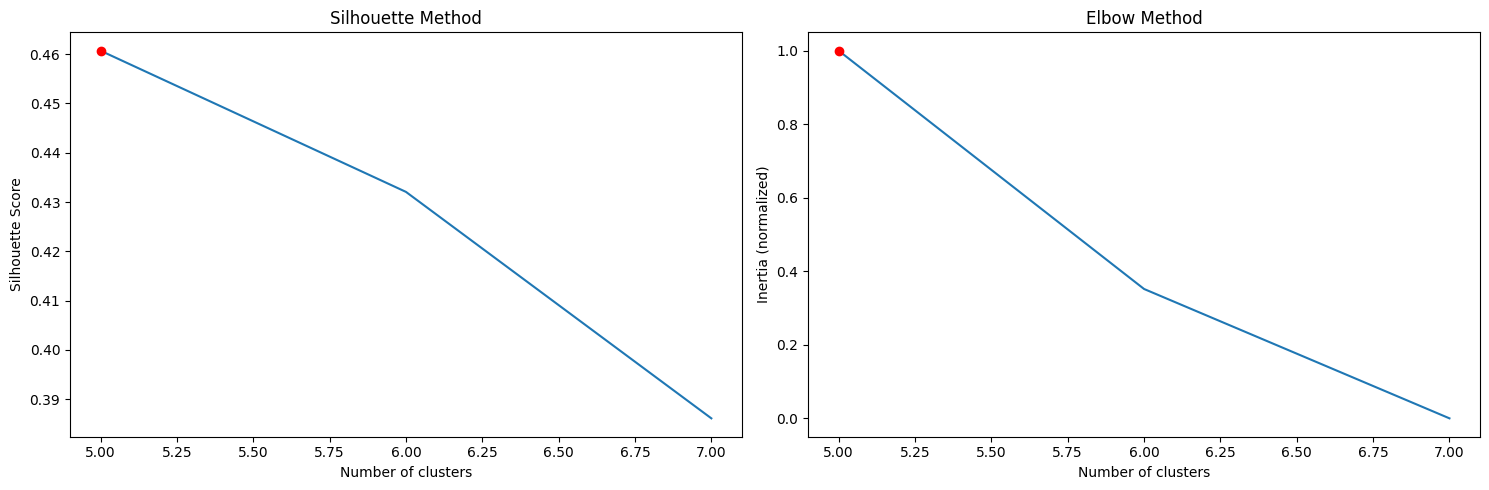

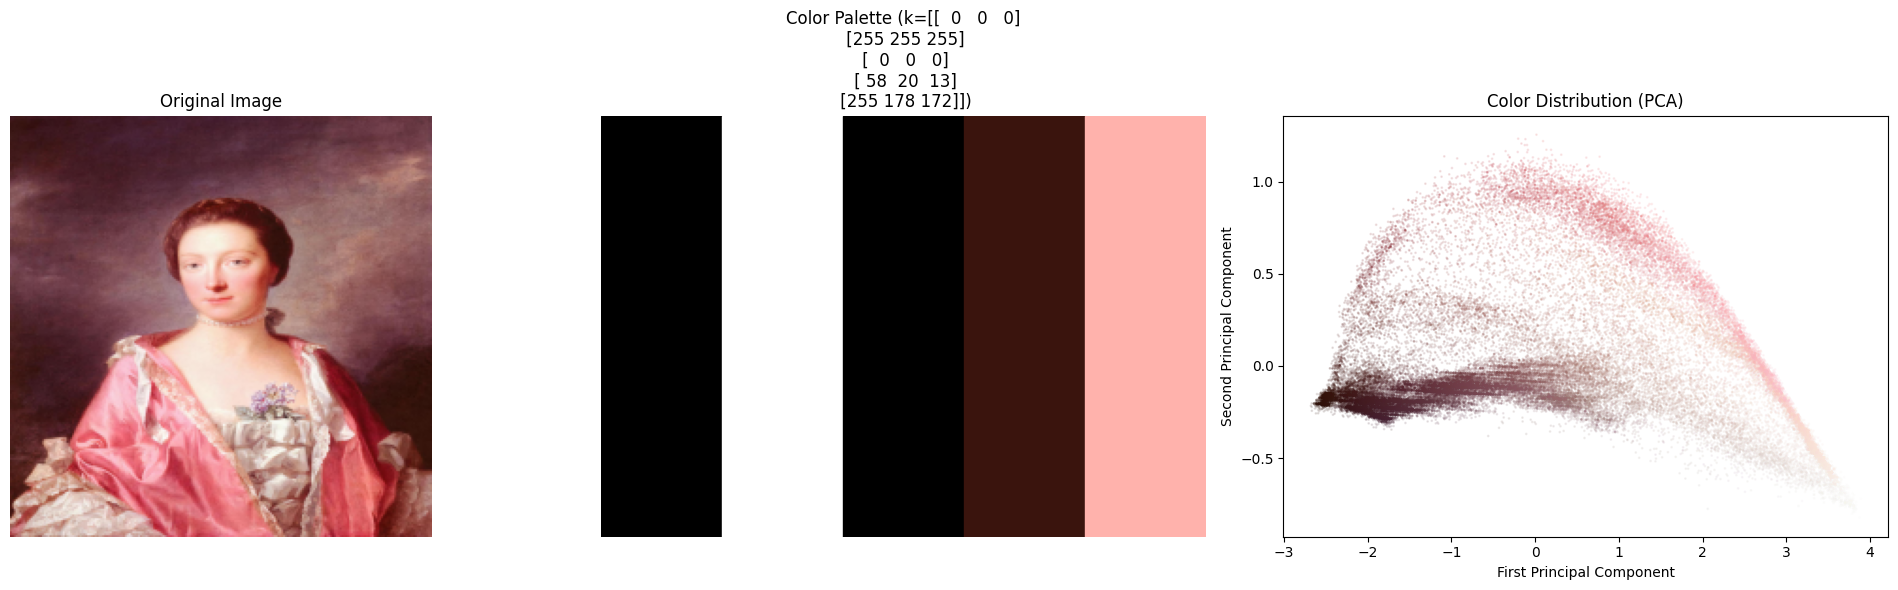

In [140]:
pipeline.fit_transform(images_random_test.values[1])

In [152]:
pipeline = Pipeline([('ReadImages', ReadImages()), 
                     ('ImagePreprocessor', ImagePreprocessor()),
                     ('ModelEvaluation', ModelEvaluation())
                     ])

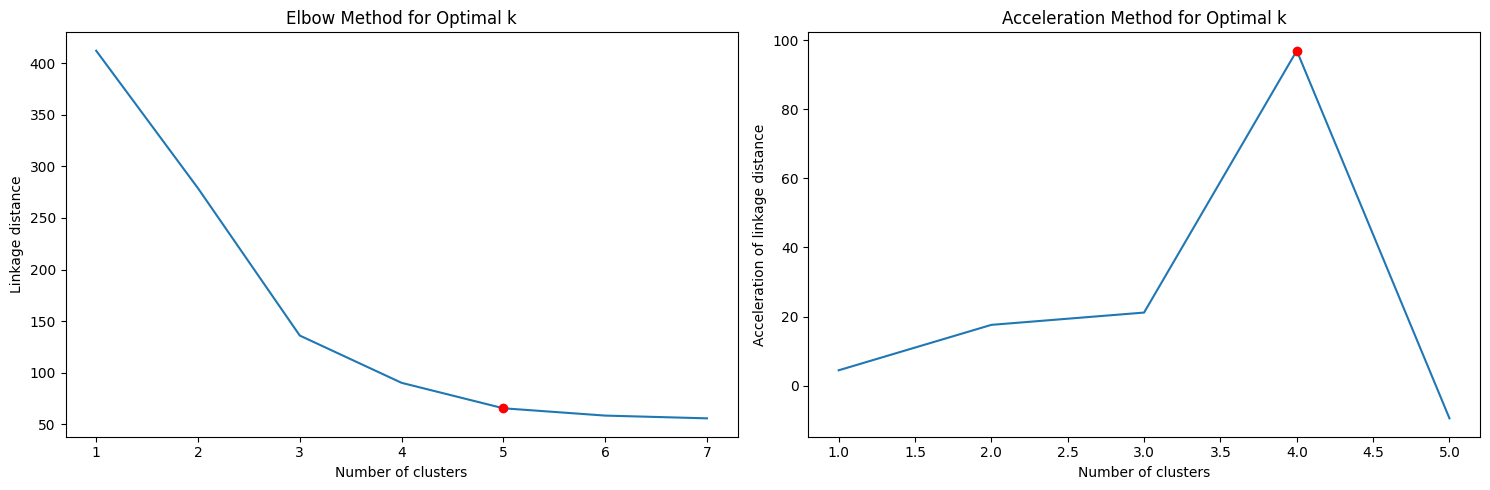

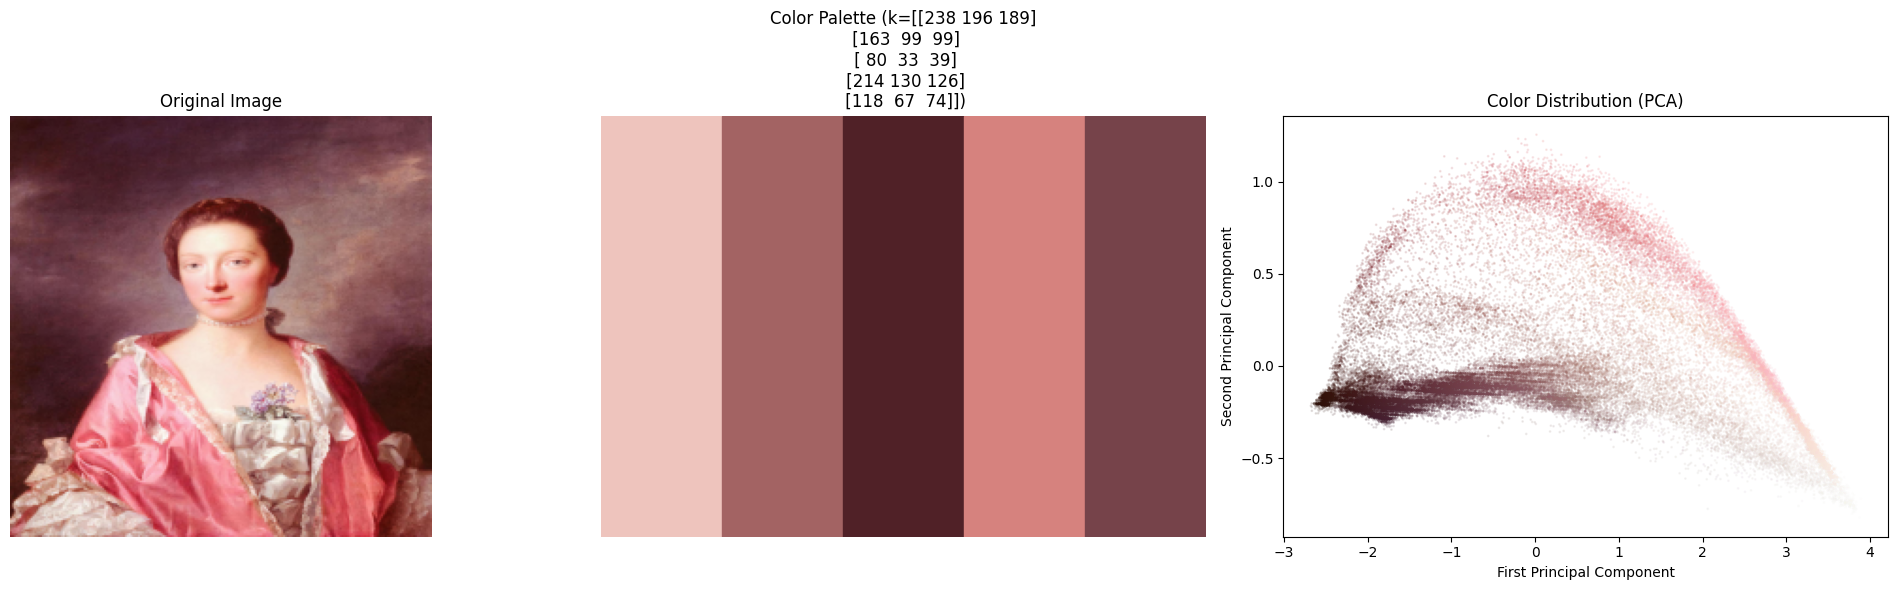

In [153]:
pipeline.fit_transform(images_random.values[1])

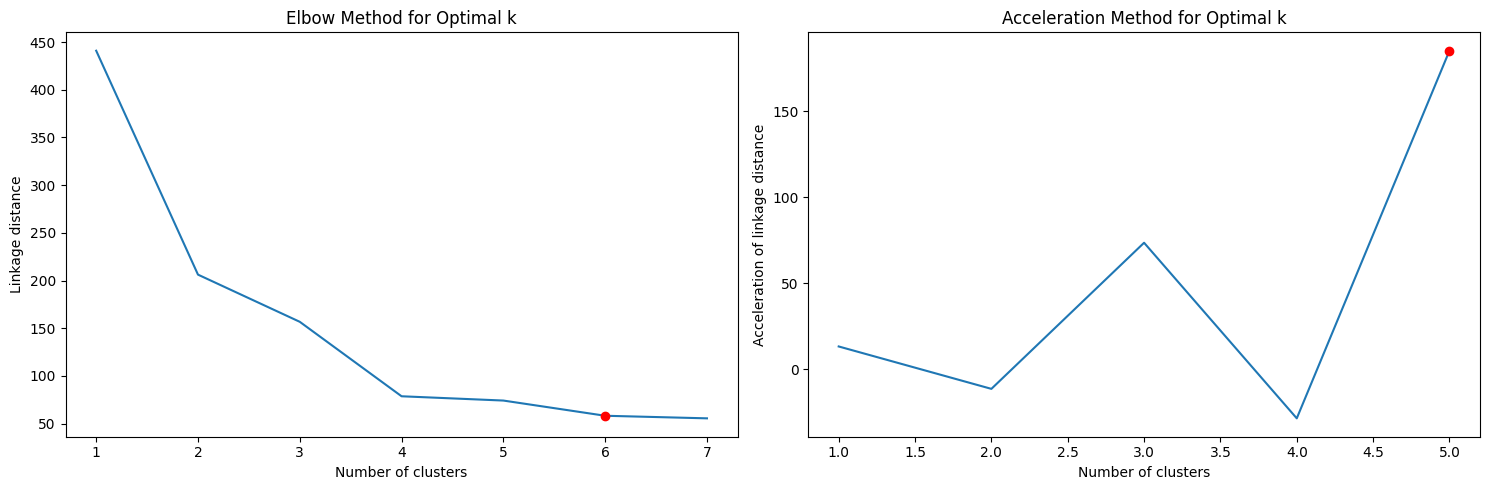

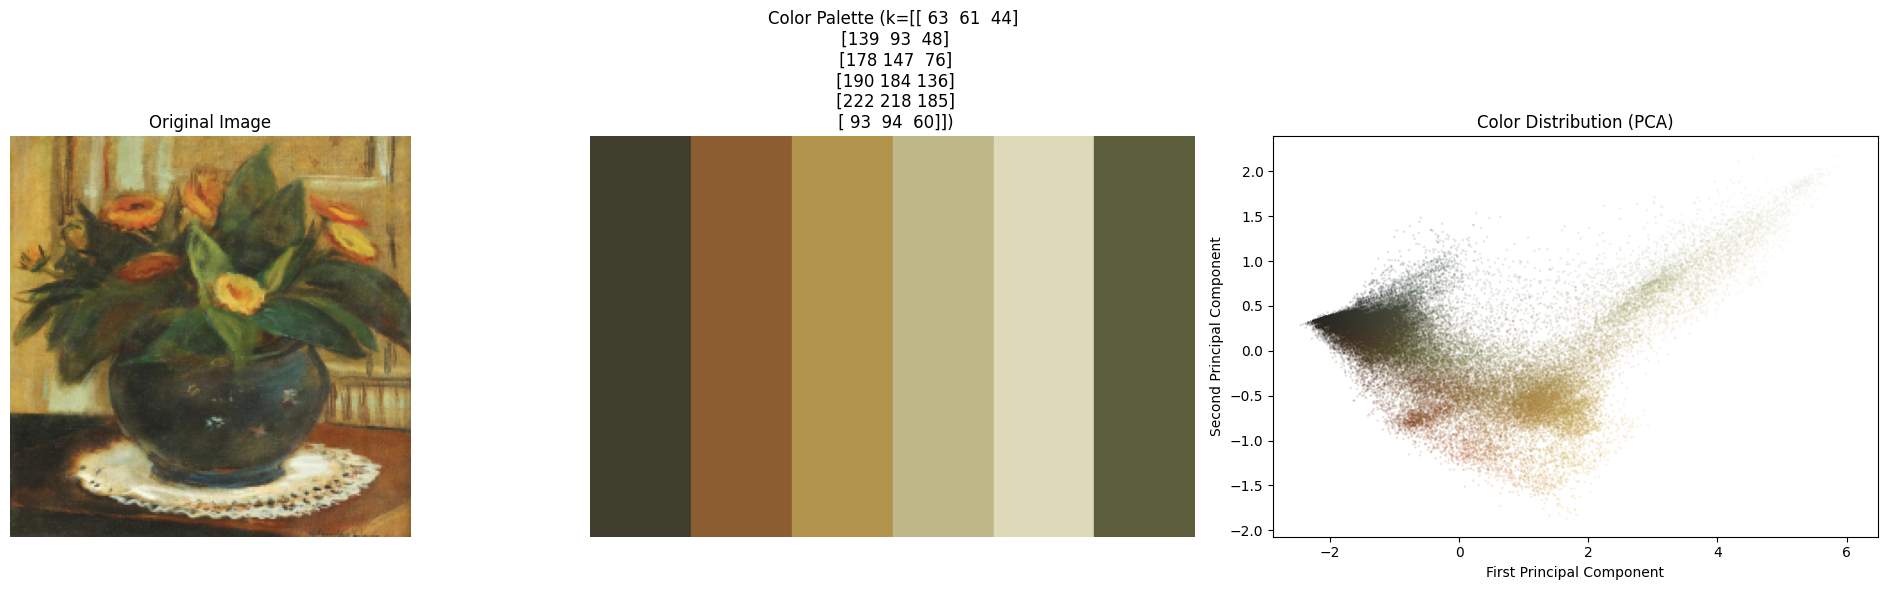

In [154]:
pipeline.fit_transform(images_random.values[2])